In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from variational import *
from normalizing_flow import *

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
N_TOT = mnist.train.images.shape[0]

In [12]:
BATCH_EX = 1
MC_EX = 10
lat_dim = 2
obs_dim = 28 * 28

graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(dtype=tf.float64, shape=[BATCH_EX, obs_dim], name='input')
    encoder = tf.squeeze(
        MultiLayerPerceptron(x, layers=[128, 128, lat_dim]).get_output_layer())
    encoder_noise = tf.squeeze(
        MultiLayerPerceptron(x, layers=[128, 128, lat_dim]).get_output_layer()) + 0.01
    
    q = FlowRandomVariable(
        dim=lat_dim, num_layers=4,
        base_dist=tf.distributions.Normal(loc=encoder, scale=tf.square(encoder_noise)))

    z, log_q = q.sample_log_prob(n_samples=MC_EX)

    decoder = tf.squeeze(
        MultiLayerPerceptron(z, layers=[128, 128, obs_dim]).get_output_layer())
    decoder_noise = tf.squeeze(
        MultiLayerPerceptron(z, layers=[128, 128, obs_dim]).get_output_layer()) + 0.01
    p = tf.distributions.Normal(loc=decoder, scale=tf.square(decoder_noise))
    x_hat = tf.squeeze(p.sample(1))

    prior = tf.distributions.Normal(loc=np.zeros(lat_dim), scale=np.ones(lat_dim))
    # ELBO
    loss = tf.reduce_sum(
        - tf.reduce_sum(p.log_prob(x), axis=1) - tf.reduce_sum(prior.log_prob(z), axis=1) + log_q)
    train_op = tf.train.AdagradOptimizer(learning_rate=.01).minimize(loss)
    my_sess = tf.Session()
    my_sess.run(tf.global_variables_initializer())

losses = []
TOT_ITERATIONS = 0

In [13]:
N_STEPS = 100000

with graph.as_default():
    for i in tqdm(range(N_STEPS)):
        idx = i % N_TOT
        observation = mnist.train.images[np.newaxis, idx, :]
        _, elbo = my_sess.run(
            [train_op, loss], feed_dict={'input:0': observation})
        losses.append(elbo)
        TOT_ITERATIONS += 1

100%|██████████| 100000/100000 [10:33<00:00, 157.75it/s]


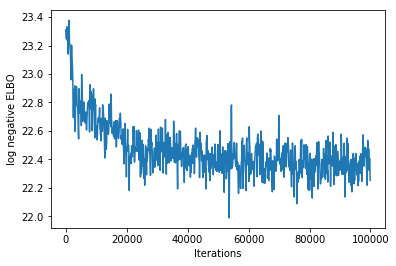

In [14]:
skip_ = 100
iterations_ = np.arange(0, TOT_ITERATIONS, skip_).astype('int')
log_losses = np.log(np.mean(np.reshape(
    np.array(losses), [len(losses)/skip_, skip_]), axis=1))
plt.plot(iterations_, log_losses)
plt.xlabel('Iterations')
plt.ylabel('log negative ELBO')
plt.show()

# Latent Probabilistic Codes of Digits

In [15]:
recs = []
codes = []
with graph.as_default():
    for i in tqdm(range(N_TOT)):
        observation = mnist.train.images[np.newaxis, i, :]
        code_, rec_ = my_sess.run(
            [z, x_hat], feed_dict={'input:0': observation})
        recs.append(rec_)
        codes.append(code_)
        losses.append(elbo)
        TOT_ITERATIONS += 1

100%|██████████| 55000/55000 [02:50<00:00, 323.13it/s]


In [16]:
codes1 = np.squeeze(np.array(codes)[:, 1, :])
recs1 = np.squeeze(np.array(recs)[:, 1, :])
recs1.shape

(55000, 784)

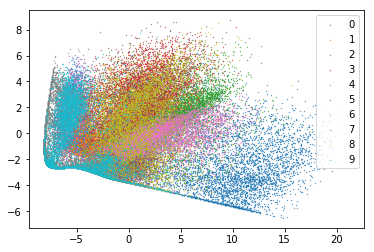

In [17]:
from  sklearn.decomposition import PCA
idx = []

codes = np.array(codes)

pca = PCA(n_components=2)
x_ = pca.fit_transform(np.squeeze(codes[:, 0, :]))

for i in range(0, 10):
    idx.append(mnist.train.labels[:, i] == 1)

for i in range(0, 10):
    plt.scatter(x_[idx[i], 0], x_[idx[i], 1], s=0.1)
plt.legend(range(0, 10))
plt.show()

# Samples from the Generative Model

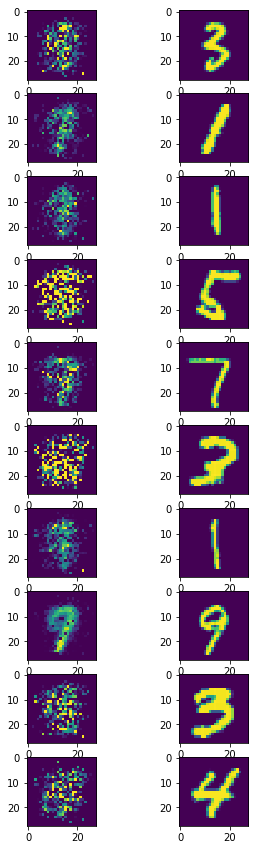

In [19]:
off_set = 40000
fig, ax = plt.subplots(10, 2)
for j in range(10):
    ax[j, 0].imshow(np.reshape(recs[off_set + j][0, :], [28, 28]), vmin=0, vmax=1)
    ax[j, 1].imshow(np.reshape(mnist.train.images[off_set + j, :], [28, 28]), vmin=0, vmax=1)
fig.set_size_inches(5, 15)
plt.show()

In [10]:
my_sess.close()